In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch
import os

import sys
sys.path.insert(0, '../trainingdata')
from datasaver import *
sys.path.insert(0, '../testproblems/tdarcy')
from manufacturedsolutions import *
sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from NeuralOperator import NeuralOperator
from customlosses import *
from quadrature import *
from customlayers import discretize_functions
from basisfunctions import *

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from NeuralOperator import NeuralOperator

logdir = '../../../nnlogs'
device = 'cuda:3'


from NeuralOperator import NeuralOperator

logdir = '../../../nnlogs'
device = 'cuda:3'

sublogdir = 'tdd'

projection = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)
projection.hparams['modeltype'] = 'projection'
projection.hparams['dtype'] = torch.float64
projection.hparams['Dt'] = 0.02
projection.__init__(projection.hparams)

FEM = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)
FEM.hparams['modeltype'] = 'FEM'
FEM.hparams['dtype'] = torch.float64
FEM.hparams['Neumannseries'] = False
FEM.hparams['Neumannseries_order'] = None
FEM.hparams['project_materialparameters'] = False
FEM.hparams['project_rhs'] = False
FEM.hparams['gamma_stabilization'] = 0
FEM.hparams['Dt'] = 0.02
FEM.__init__(FEM.hparams)

FEM_projtheta = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)
FEM_projtheta.hparams['modeltype'] = 'FEM'
FEM_projtheta.hparams['dtype'] = torch.float64
FEM_projtheta.hparams['Neumannseries'] = False
FEM_projtheta.hparams['Neumannseries_order'] = None
FEM_projtheta.hparams['project_materialparameters'] = True
FEM_projtheta.hparams['project_rhs'] = False
FEM_projtheta.hparams['gamma_stabilization'] = 0
FEM_projtheta.hparams['Dt'] = 0.02
FEM_projtheta.__init__(FEM_projtheta.hparams)

modeldict = {'Projection': projection,
             'FEM': FEM,
             'FEM': FEM_projtheta}

Projection
1
2
3
4
5
FEM
1
2
3
4
5


/tmp/ipykernel_2880968/1892792972.py:71: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))


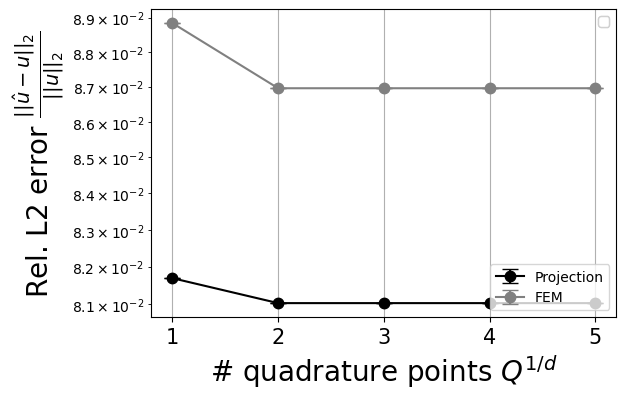

In [10]:
N_samples = 1

values = [1,2,3,4,5]

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

L2_scaled_avg = np.zeros((len(modeldict),len(values)))
yerr = np.zeros((len(modeldict),2,len(values)))

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

quadrature = GaussLegendreQuadrature(n_elements=[1,3,3], Q=[33,99,99])
# quadrature = UniformQuadrature(Q=[3,30,30])
x = quadrature.xi
w = quadrature.w
w = w*projection.hparams['Dt']

linestyles=['-','-','--','--','--','--','--','--','--','--','--','--','--','--','--']
colors = ['black','grey','C0','C1','C2','C3','C4','C5','C6','C7','C8']

linestyles=['-','-','--','--','--','--','--','--','--','--','--']
colors = ['black','grey','C3','C6','C4','C5','C0','C1','C2']

dataset = ManufacturedSolutionsSet(N_samples=N_samples, variables=['t','x','x'], l_min=[0.05,0.05,0.05], l_max=[0.05,0.05,0.05])
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u
u0 = dataset.u0

m=0
for model in modeldict:
    print(str(model))
    modeldict[str(model)].timestep = 0
    x_scaled = np.copy(x)
    x_scaled[:,0] = x_scaled[:,0]*modeldict[str(model)].hparams['Dt']

    for i in range(len(values)):
        print(values[i])
        modeldict[str(model)].hparams['Q'] = (values[i],99,99)
        modeldict[str(model)].__init__(modeldict[str(model)].hparams)
        u_exact = discretize_functions(u, x_scaled)
        u_hat = modeldict[str(model)].simforward(theta, f, etab, etat, gl, gr, u0, x, u)
        L2_scaled_array = weightedrelativeL2_set(w, u_hat, u_exact)
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
    m+=1

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'# quadrature points $Q^{1/d}$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_yscale('log')
# ax.set_xlim(0, 1.05)

ax.grid()
for model in modeldict:
    plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
    m+=1
# plt.legend(fontsize=10, ncols=2, loc='lower right')
legend1 = ax.legend(handles=plots[0:2],fontsize=10, ncols=1, loc='lower right')
plt.gca().add_artist(legend1)
legend2 = ax.legend(handles=plots[2:],fontsize=10, ncols=2, loc='upper right')
plt.gca().add_artist(legend2)

plt.savefig("qtime_5e-2.svg", bbox_inches='tight')#, transparent=True)

plt.show()

Projection
2
5
10
20
33
50
100
FEM
2
5
10
20
33
50
100
FEM (projected theta)
2
5
10
20
33
50
100


/tmp/ipykernel_2143197/910781041.py:70: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(3*np.array(values), L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))


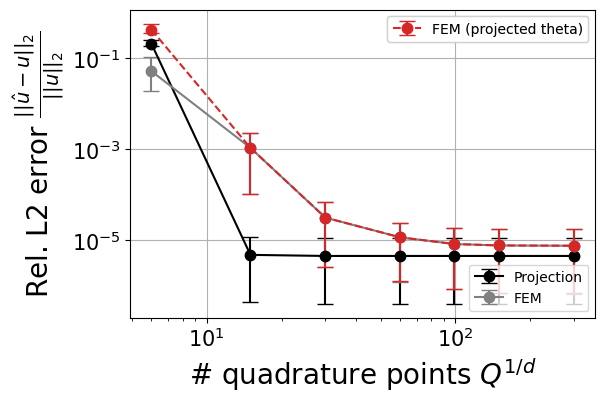

In [8]:
N_samples = 1

values = [2,5,10,20,33,50,100]

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

L2_scaled_avg = np.zeros((len(modeldict),len(values)))
yerr = np.zeros((len(modeldict),2,len(values)))

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

quadrature = GaussLegendreQuadrature(n_elements=[1,3,3], Q=[2,99,99])
# quadrature = UniformQuadrature(Q=[3,30,30])
x = quadrature.xi
w = quadrature.w
w = w*projection.hparams['Dt']
x_scaled = np.copy(x)
x_scaled[:,0] = x_scaled[:,0]*modeldict[str(model)].hparams['Dt']

linestyles=['-','-','--','--','--','--','--','--','--','--','--','--','--','--','--']
colors = ['black','grey','C0','C1','C2','C3','C4','C5','C6','C7','C8']

linestyles=['-','-','--','--','--','--','--','--','--','--','--']
colors = ['black','grey','C3','C6','C4','C5','C0','C1','C2']

dataset = ManufacturedSolutionsSet(N_samples=N_samples, variables=['t','x','x'], l_min=[0.05,0.05,0.05], l_max=[0.05,0.05,0.05])
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u
u0 = dataset.u0

m=0
for model in modeldict:
    print(str(model))
    for i in range(len(values)):
        print(values[i])
        modeldict[str(model)].hparams['Q'] = (2,3*values[i],3*values[i])
        modeldict[str(model)].__init__(modeldict[str(model)].hparams)
        u_exact = discretize_functions(u, x_scaled)
        u_hat = modeldict[str(model)].simforward(theta, f, etab, etat, gl, gr, u0, x, u)
        L2_scaled_array = weightedrelativeL2_set(w, u_hat, u_exact)
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
    m+=1

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'# quadrature points $Q^{1/d}$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(0, 1.05)

ax.grid()
for model in modeldict:
    plots.append(ax.errorbar(3*np.array(values), L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
    m+=1
# plt.legend(fontsize=10, ncols=2, loc='lower right')
legend1 = ax.legend(handles=plots[0:2],fontsize=10, ncols=1, loc='lower right')
plt.gca().add_artist(legend1)
legend2 = ax.legend(handles=plots[2:],fontsize=10, ncols=2, loc='upper right')
plt.gca().add_artist(legend2)

plt.savefig("Qspace.svg", bbox_inches='tight')#, transparent=True)

plt.show()

Projection
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
FEM
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


/tmp/ipykernel_2143197/3553120839.py:70: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(3*np.array(values), L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))


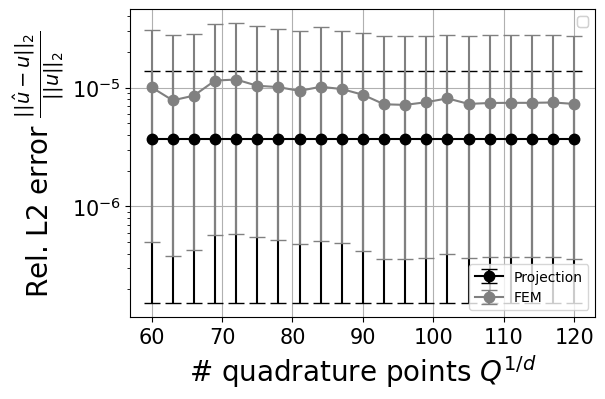

In [16]:
N_samples = 1000

values = [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

L2_scaled_avg = np.zeros((len(modeldict),len(values)))
yerr = np.zeros((len(modeldict),2,len(values)))

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

quadrature = GaussLegendreQuadrature(n_elements=[1,3,3], Q=[2,99,99])
# quadrature = UniformQuadrature(Q=[3,30,30])
x = quadrature.xi
w = quadrature.w
w = w*projection.hparams['Dt']
x_scaled = np.copy(x)
x_scaled[:,0] = x_scaled[:,0]*projection.hparams['Dt']

linestyles=['-','-','--','--','--','--','--','--','--','--','--','--','--','--','--']
colors = ['black','grey','C0','C1','C2','C3','C4','C5','C6','C7','C8']

linestyles=['-','-','--','--','--','--','--','--','--','--','--']
colors = ['black','grey','C3','C6','C4','C5','C0','C1','C2']

dataset = ManufacturedSolutionsSet(N_samples=N_samples, variables=['t','x','x'], l_min=[1,1,1], l_max=[1,1,1])
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u
u0 = dataset.u0

m=0
for model in modeldict:
    print(str(model))
    for i in range(len(values)):
        print(values[i])
        modeldict[str(model)].hparams['Q'] = (2,3*values[i],3*values[i])
        modeldict[str(model)].__init__(modeldict[str(model)].hparams)
        u_exact = discretize_functions(u, x_scaled)
        u_hat = modeldict[str(model)].simforward(theta, f, etab, etat, gl, gr, u0, x, u)
        L2_scaled_array = weightedrelativeL2_set(w, u_hat, u_exact)
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
    m+=1

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'# quadrature points $Q^{1/d}$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(0, 1.05)

ax.grid()
for model in modeldict:
    plots.append(ax.errorbar(3*np.array(values), L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
    m+=1
# plt.legend(fontsize=10, ncols=2, loc='lower right')
legend1 = ax.legend(handles=plots[0:2],fontsize=10, ncols=1, loc='lower right')
plt.gca().add_artist(legend1)
legend2 = ax.legend(handles=plots[2:],fontsize=10, ncols=2, loc='upper right')
plt.gca().add_artist(legend2)

# plt.savefig("Qspace.svg", bbox_inches='tight')#, transparent=True)

plt.show()

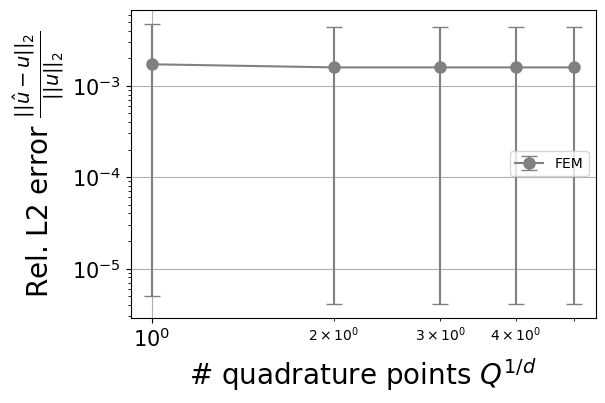

In [ ]:
N_samples = 10
l_min = [1,1,1]
l_max = [1,1,1]

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

quadrature = GaussLegendreQuadrature(n_elements=[1,3,3], Q=[33,99,99])
x = quadrature.xi
x_scaled = np.copy(x)
x_scaled[:,0] = x_scaled[:,0]*model.hparams['Dt']
w = quadrature.w
w = w*model.hparams['Dt']

linestyles = ['-','--','--','--','--']
colors = ['C0','C1','C2','C1','C2','C2','C4','C5','C6']

dataset = ManufacturedSolutionsSet(N_samples=N_samples, variables=['t','x','x'], l_min=l_min, l_max=l_max)
theta = dataset.theta
f = dataset.f
eta_yL = dataset.etat
eta_y0 = dataset.etab
g_x0 = dataset.gl
g_xL = dataset.gr
u = dataset.u
u0 = dataset.u0

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

# L2_scaled_avg = np.zeros((len(values)))
# yerr = np.zeros((2,len(values)))
# for i in range(len(values)):
#     model.hparams['modeltype'] = 'projection'
#     model.hparams['dtype'] = torch.float64
#     model.hparams['precision'] = 64
#     model.hparams['Q'] = (values[i],99,99)
#     model.__init__(model.hparams)
#     u_exact = discretize_functions(u, x_scaled)
#     u_hat = model.simforward(theta, f, eta_y0, eta_yL, g_x0, g_xL, u0, x, u)
#     L2_scaled_array = weightedrelativeL2_set(w, u_hat, u_exact)
#     L2_scaled_avg[i] = np.average(L2_scaled_array)
#     q_l = np.quantile(L2_scaled_array, q_low)
#     q_h = np.quantile(L2_scaled_array, q_high)
#     yerr[:,i] = np.array([L2_scaled_avg[i] - q_l, -L2_scaled_avg[i] + q_h])

# ax.errorbar(values, L2_scaled_avg, yerr=yerr,  capsize=6, ms=8, label='Projection', color='black', linestyle='-', marker='o')

L2_scaled_avg = np.zeros((len(values)))
yerr = np.zeros((2,len(values)))
for i in range(len(values)):
    model.hparams['modeltype'] = 'FEM'
    model.hparams['dtype'] = torch.float64
    model.hparams['precision'] = 64
    model.hparams['Q'] = (values[i],99,99)
    model.__init__(model.hparams)
    u_exact = discretize_functions(u, x_scaled)
    u_hat = model.simforward(theta, f, eta_y0, eta_yL, g_x0, g_xL, u0, x, u)
    L2_scaled_array = weightedrelativeL2_set(w, u_hat, u_exact)
    L2_scaled_avg[i] = np.average(L2_scaled_array)
    q_l = np.quantile(L2_scaled_array, q_low)
    q_h = np.quantile(L2_scaled_array, q_high)
    yerr[:,i] = np.array([L2_scaled_avg[i] - q_l, -L2_scaled_avg[i] + q_h])



ax.errorbar(values, L2_scaled_avg, yerr=yerr,  capsize=6, ms=8, label='FEM', color='grey', linestyle='-', marker='o')

ax.tick_params(axis='both', labelsize=size_ticklabels)
# ax.set_title(r'$0.5<\lambda<1$', fontsize=size_title)
ax.set_xlabel(r'# quadrature points $Q^{1/d}$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-6,1e1)
ax.grid()
plt.legend(fontsize=10)
plt.savefig("Qtime.svg", bbox_inches='tight')#, transparent=True)
plt.show()

In [7]:
from NeuralOperator import NeuralOperator

logdir = '../../../nnlogs'
device = 'cuda:3'


sublogdir = 'test'
model = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)
model.hparams['n_timesteps'] = 1

values = [4,5,6,7,8,9,10,11,12]

N_samples = 1
l_min = [0.05,0.05,0.05]
l_max = [0.05,0.05,0.05]

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

quadrature = GaussLegendreQuadrature(n_elements=[1,3,3], Q=[33,99,99])
x = quadrature.xi
x_scaled = np.copy(x)
x_scaled[:,0] = x_scaled[:,0]*model.hparams['Dt']
w = quadrature.w
w = w*model.hparams['Dt']

In [ ]:
linestyles = ['-','--','--','--','--']
colors = ['C0','C1','C2','C1','C2','C2','C4','C5','C6']

dataset = ManufacturedSolutionsSet(N_samples=N_samples, variables=['t','x','x'], l_min=l_min, l_max=l_max)
theta = dataset.theta
f = dataset.f
eta_yL = dataset.etat
eta_y0 = dataset.etab
g_x0 = dataset.gl
g_xL = dataset.gr
u = dataset.u
u0 = dataset.u0

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

L2_scaled_avg = np.zeros((len(values)))
yerr = np.zeros((2,len(values)))
for i in range(len(values)):
    model.hparams['modeltype'] = 'projection'
    model.hparams['dtype'] = torch.float64
    model.hparams['precision'] = 64
    model.hparams['Q'] = (99,3*values[i],3*values[i])
    model.__init__(model.hparams)
    u_exact = discretize_functions(u, x_scaled)
    u_hat = model.simforward(theta, f, eta_y0, eta_yL, g_x0, g_xL, u0, x, u)
    L2_scaled_array = weightedrelativeL2_set(w, u_hat, u_exact)
    L2_scaled_avg[i] = np.average(L2_scaled_array)
    q_l = np.quantile(L2_scaled_array, q_low)
    q_h = np.quantile(L2_scaled_array, q_high)
    yerr[:,i] = np.array([L2_scaled_avg[i] - q_l, -L2_scaled_avg[i] + q_h])

ax.errorbar(3*np.array(values), L2_scaled_avg, yerr=yerr,  capsize=6, ms=8, label='Projection', color='black', linestyle='-', marker='o')

L2_scaled_avg = np.zeros((len(values)))
yerr = np.zeros((2,len(values)))
for i in range(len(values)):
    model.hparams['modeltype'] = 'FEM'
    model.hparams['dtype'] = torch.float64
    model.hparams['precision'] = 64
    model.hparams['Q'] = (99,3*values[i],3*values[i])
    model.__init__(model.hparams)
    u_exact = discretize_functions(u, x_scaled)
    u_hat = model.simforward(theta, f, eta_y0, eta_yL, g_x0, g_xL, u0, x, u)
    L2_scaled_array = weightedrelativeL2_set(w, u_hat, u_exact)
    L2_scaled_avg[i] = np.average(L2_scaled_array)
    q_l = np.quantile(L2_scaled_array, q_low)
    q_h = np.quantile(L2_scaled_array, q_high)
    yerr[:,i] = np.array([L2_scaled_avg[i] - q_l, -L2_scaled_avg[i] + q_h])

ax.errorbar(3*np.array(values), L2_scaled_avg, yerr=yerr,  capsize=6, ms=8, label='FEM', color='grey', linestyle='-', marker='o')

ax.tick_params(axis='both', labelsize=size_ticklabels)
# ax.set_title(r'$0.5<\lambda<1$', fontsize=size_title)
ax.set_xlabel(r'# quadrature points $Q^{1/d}$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-6,1e1)
ax.grid()
plt.legend(fontsize=10)
plt.savefig("Qspace.svg", bbox_inches='tight')#, transparent=True)
plt.show()